In [313]:
import numpy as np
import matplotlib.pyplot as plt

In [314]:
from loaders import clean_text_for_pattern_letter
from temp_text import template_str
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', '\'', '1']
print(f'{letters=}')

len(letters)=32
500
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', "'", '1']


In [315]:
# train
max_index = 4

next_index: dict[str, int] = {}
index_by_prev: dict[str, dict] = {}

StatsDict: dict[str, dict] = {}

for letter in letters:
    next_index[letter] = 1

for inp_idx, inp in enumerate(input_str):
    if inp_idx <= 0 or inp_idx == len(input_str) - 1:
        continue

    prev_idx = inp_idx - 1
    prev_inp = input_str[prev_idx]
    
    inp_index = next_index[inp]

    prev_index = next_index[prev_inp]

    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
    StatsDict.setdefault(stats_key, {})

    next_inp = input_str[inp_idx + 1]
    StatsDict[stats_key].setdefault(next_inp, 0)

    StatsDict[stats_key][next_inp] += 1

    by_prev_key = prev_inp + str(prev_index) + ':' + inp
    index_by_prev.setdefault(by_prev_key, {})
    index_by_prev[by_prev_key].setdefault(inp_index, 0)
    index_by_prev[by_prev_key][inp_index] += 1

    by_prev_key = prev_inp + str(0) + ':' + inp
    index_by_prev.setdefault(by_prev_key, {})
    index_by_prev[by_prev_key].setdefault(inp_index, 0)
    index_by_prev[by_prev_key][inp_index] += 1

    # next_index[inp] += 1
    # if next_index[inp] > max_index:
    #     next_index[inp] = 1
    
    next_index[prev_inp] += 1
    if next_index[prev_inp] > max_index:
        next_index[prev_inp] = 1


In [316]:
for sdk, sdv in index_by_prev.items():
    print(sdk, sdv)
    print('')

t1:h {1: 2}

t0:h {1: 4, 2: 2, 3: 3, 4: 2}

h1:e {1: 1, 4: 3}

h0:e {1: 1, 3: 3, 4: 5, 2: 4}

e1:  {1: 2, 4: 1}

e0:  {1: 6, 3: 4, 4: 4, 2: 3}

 1:s {1: 1}

 0:s {1: 1, 3: 2, 4: 1, 2: 2}

s1:k {1: 1}

s0:k {1: 1}

k1:y {1: 1}

k0:y {1: 1}

y1:  {2: 1}

y0:  {2: 1, 1: 2, 3: 1}

 2:a {1: 1}

 0:a {1: 3, 3: 5, 2: 2, 4: 2}

a1:b {1: 1}

a0:b {1: 1}

b1:o {1: 1}

b0:o {1: 1, 2: 2}

o1:v {1: 1}

o0:v {1: 1}

v1:e {2: 1}

v0:e {2: 1, 3: 2, 1: 1}

e2:  {3: 3, 2: 1, 1: 2}

 3:t {2: 2, 3: 1, 4: 1}

 0:t {2: 5, 4: 3, 1: 3, 3: 3}

t2:h {2: 2, 1: 2, 4: 1}

h2:e {3: 2, 2: 2}

e3:  {4: 2, 1: 1, 2: 2}

 4:p {1: 1}

 0:p {1: 2, 4: 1}

p1:o {2: 1}

p0:o {2: 1}

o2:r {1: 2}

o0:r {1: 3, 2: 2, 4: 1}

r1:t {3: 1}

r0:t {3: 1}

t3:  {1: 1}

t0:  {1: 2, 4: 1}

 1:w {1: 1}

 0:w {1: 1, 2: 2, 4: 2, 3: 2}

w1:a {2: 1}

w0:a {2: 3, 1: 2}

a2:s {2: 2, 1: 1}

a0:s {2: 2, 1: 3, 3: 3}

s2:  {2: 1, 4: 1}

s0:  {2: 2, 4: 7, 1: 2, 3: 3}

 2:t {4: 1, 2: 1, 3: 2}

t4:h {3: 2, 4: 1}

h3:e {4: 2, 2: 1}

e4:  {3: 1, 1: 1, 4

In [317]:
for sdk, sdv in StatsDict.items():
    print(sdk, sdv)
    print('')

t1:h1 {'e': 2}

h1:e1 {' ': 1}

e1: 1 {'s': 1, 'd': 1}

 1:s1 {'k': 1}

s1:k1 {'y': 1}

k1:y1 {' ': 1}

y1: 2 {'a': 1}

 2:a1 {'b': 1}

a1:b1 {'o': 1}

b1:o1 {'v': 1}

o1:v1 {'e': 1}

v1:e2 {' ': 1}

e2: 3 {'t': 1, 's': 1, 'c': 1}

 3:t2 {'h': 2}

t2:h2 {'e': 2}

h2:e3 {' ': 2}

e3: 4 {'p': 1, 'f': 1}

 4:p1 {'o': 1}

p1:o2 {'r': 1}

o2:r1 {'t': 1, 'd': 1}

r1:t3 {' ': 1}

t3: 1 {'w': 1}

 1:w1 {'a': 1}

w1:a2 {'s': 1}

a2:s2 {' ': 1, 'e': 1}

s2: 2 {'t': 1}

 2:t4 {'h': 1}

t4:h3 {'e': 1, 'i': 1}

h3:e4 {' ': 1, 'a': 1}

e4: 3 {'c': 1}

 3:c1 {'o': 1}

c1:o3 {'l': 1}

o3:l1 {'o': 1}

l1:o4 {'r': 1}

o4:r2 {' ': 2}

r2: 4 {'o': 1}

 4:o1 {'f': 1}

o1:f1 {' ': 1}

f1: 1 {'t': 1}

 1:t1 {'e': 1}

t1:e1 {'l': 1, 's': 1}

e1:l2 {'e': 1}

l2:e2 {'v': 1}

e2:v2 {'i': 1, 'e': 1}

v2:i1 {'s': 1}

i1:s3 {'i': 1}

s3:i2 {'o': 1}

i2:o2 {'n': 1}

o2:n1 {',': 1, 'o': 1}

n1:,1 {' ': 1}

,1: 2 {'t': 1}

 2:t2 {'u': 1}

t2:u1 {'n': 1}

u1:n2 {'e': 1}

n2:e3 {'d': 1}

e3:d1 {' ': 1}

d1: 3 {'t': 1}



In [318]:
# infer
for letter in letters:
    next_index[letter] = 0

TF = []
err = 0

prev_index_l = [x for x in range(1, max_index+1)]

for inp_idx, inp in enumerate(input_str):
    if inp_idx <= 0 or inp_idx == len(input_str) - 1:
        continue

    prev_inp = input_str[inp_idx - 1]
    
    index_l = []
    stats_d = {}
    index_d = {}
    for prev_index in prev_index_l:
        by_prev_key = prev_inp + str(prev_index) + ':' + inp
        # print(by_prev_key)
        inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
        # print(inp_index_arr)

        for inp_index, val in inp_index_arr.items():
            if inp_index != -1:
                index_d.setdefault(inp_index, 0)
                index_d[inp_index] += val

            if inp_index != -1 and index_l.__contains__(inp_index) == False:
                index_l.append(inp_index)

                stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                stats = StatsDict.get(stats_key, {})

                next_inp = input_str[inp_idx + 1]
                # print(next_inp, stats_key, stats)
                for st_key, st in stats.items():
                    stats_d.setdefault(st_key, 0)
                    stats_d[st_key] += 1

    max_key_d = max(index_d, key=index_d.get)
    if inp == prev_inp:
        pred_max_key = max_key_d
        max_key_d += 1
        if max_key_d > max_index:
            max_key_d = 1
        
        index_d[max_key_d] = index_d[pred_max_key]
        index_d.pop(pred_max_key)

    prev_index_l = list(index_d.keys())

    if len(stats_d) > 0:
        max_key = max(stats_d, key=stats_d.get)
        print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
    
    if max_key != next_inp:
        err += 1

    tf = len(index_l)
    TF.append(tf)

print(err, err / (len(input_str) / 100) )

e e {'e': 4} [1, 2, 4, 3] {1: 4, 2: 2, 4: 2, 3: 3} [1, 2, 4, 3] False
    {' ': 4, 'a': 1, 't': 1, 'r': 1} [1, 4, 3, 2] {1: 1, 4: 5, 3: 3, 2: 4} [1, 4, 3, 2] False
s s {'s': 2, 'd': 2, 'm': 1, 'c': 1} [1, 4, 3, 2] {1: 6, 4: 4, 3: 4, 2: 3} [1, 4, 3, 2] False
p k {'k': 1, 'a': 1, 'o': 1, 'p': 2, 'h': 1} [1, 4, 3, 2] {1: 1, 4: 1, 3: 2, 2: 2} [1, 4, 3, 2] False
y y {'y': 1} [1] {1: 1} [1] False
    {' ': 1} [1] {1: 1} [1] False
a a {'a': 1} [2] {2: 1} [2] False
b b {'b': 1} [1] {1: 1} [1] False
o o {'o': 1} [1] {1: 1} [1] False
v v {'v': 1} [1] {1: 1} [1] False
e e {'e': 1} [1] {1: 1} [1] False
    {' ': 1} [2] {2: 1} [2] False
c t {'t': 1, 's': 1, 'c': 2, 'i': 1, 'f': 1} [3, 2, 1] {3: 3, 2: 1, 1: 2} [3, 2, 1] False
h h {'h': 2, 'o': 1, 'e': 1} [2, 3, 4, 1] {2: 4, 3: 3, 4: 3, 1: 1} [2, 3, 4, 1] False
e e {'e': 4, 'r': 1} [2, 1, 4, 3] {2: 2, 1: 4, 4: 2, 3: 3} [2, 1, 4, 3] False
    {' ': 4, 'r': 1, 'a': 1, 't': 1} [3, 2, 1, 4] {3: 3, 2: 4, 1: 1, 4: 5} [3, 2, 1, 4] False
s p {'p': 1, 'f': 1,

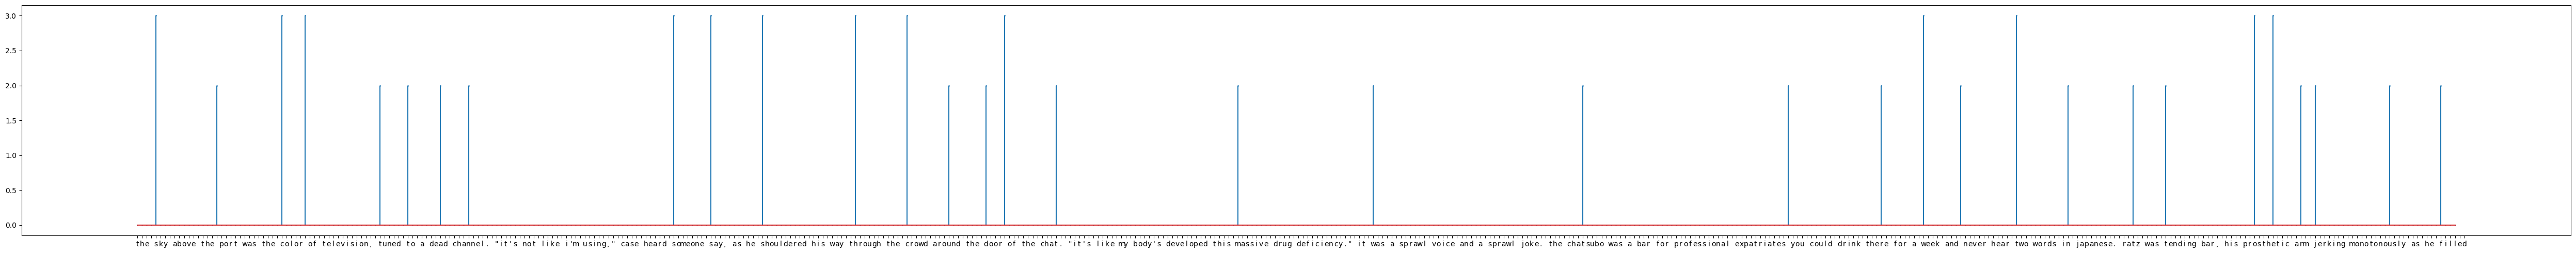

In [319]:
TF = np.array(TF, dtype=float)
TF = np.pad(TF, (1, 0))[:-1] - TF
# TF = TF - np.pad(TF, (1, 0))[:-1] 
# TF = np.pad(TF, (1, 0))[:-1] - TF
# TF = TF - np.pad(TF, (0, 1))[-1:]
# print(TF)
TF[np.where(TF < 0)] = 0
# TF = np.abs(TF)
TF[np.where(TF <= np.mean(TF[np.where(TF > 0)]))] = 0
# # TF[np.where(TF <= 0.5)] = 0
# print(TF.size, TF.max(), TF.min())

fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
# axs.plot(np.arange(TF.size), TF)
markerline, stemline, baseline, = axs.stem(np.arange(TF.size), TF)
plt.setp(markerline, markersize = 1)
axs.xaxis.set_ticks(np.arange(len(input_str)) ,input_str)
# axs.xaxis.grid(True)

plt.show()